In [2]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os

load_dotenv()

GROQ_MODEL = os.getenv("GROQ_MODEL")
GROQ_API = os.getenv("GROQ_API_KEY")
llm = ChatGroq(api_key=GROQ_API, model=GROQ_MODEL)


In [3]:
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor


def book_hotel(hotel_name: str):
    """Book a hotel"""
    return f"Successfully booked a stay at {hotel_name}."


def book_flight(from_airport: str, to_airport: str):
    """Book a flight"""
    return f"Successfully booked a flight from {from_airport} to {to_airport}."


flight_assistant = create_react_agent(
    llm,
    tools=[book_flight],
    prompt="You are a flight booking assistant",
    name="flight_assistant"
)


hotel_assistant = create_react_agent(
    llm,
    tools=[book_hotel],
    prompt="You are a hotel booking assistant.",
    name="hotel_assistant"
)


In [4]:
supervisor = create_supervisor(
    agents=[flight_assistant, hotel_assistant],
    model=llm,
    prompt=(
        "You manage a hotel booking assistant and a"
        "flight booking assistant. Assign work to them."
    )
).compile()


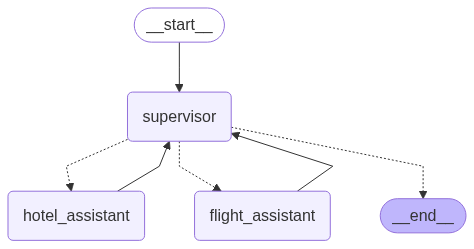

In [5]:
from IPython.display import Image, display
display(Image(supervisor.get_graph().draw_mermaid_png()))


In [6]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "book a flight from BOS to JFK and a stay at McKittrick Hotel"
                )
            }
        ]
    }
):
    print(chunk)
    print("\n")


{'supervisor': None}


{'hotel_assistant': {'messages': [AIMessage(content="I'm happy to help you with your booking. I've been transferred to the hotel assistant.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 976, 'total_tokens': 996, 'completion_time': 0.017279506, 'prompt_time': 0.121665549, 'queue_time': 0.2657792, 'total_time': 0.138945055}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_f974fb141b', 'finish_reason': 'stop', 'logprobs': None}, name='hotel_assistant', id='run-8924c3ce-3b4a-42af-acee-08b1ff673754-0', usage_metadata={'input_tokens': 976, 'output_tokens': 20, 'total_tokens': 996}), AIMessage(content='Transferring back to supervisor', additional_kwargs={}, response_metadata={'__is_handoff_back': True}, name='hotel_assistant', tool_calls=[{'name': 'transfer_back_to_supervisor', 'args': {}, 'id': '71ed68ae-ed8b-4a0f-83e1-193b3983d9aa', 'type': 'tool_call'}]), ToolMessage(content='Successfully transferred ba

In [7]:
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_swarm, create_handoff_tool

transfer_to_hotel_assistant = create_handoff_tool(
    agent_name="hotel_assistant",
    description="Transfer user to the hotel-booking assistant.",
)

transfer_to_flight_assistant = create_handoff_tool(
    agent_name="flight_assistant",
    description="Transfer user to the flight-booking assistant.",
)

flight_assistant = create_react_agent(
    llm,
    tools=[book_flight, transfer_to_hotel_assistant],
    prompt="You are a flight booking assistant",
    name="flight_assistant"
)

hotel_assistant = create_react_agent(
    llm,
    tools=[book_hotel, transfer_to_flight_assistant],
    prompt="You are a hotel booking assistant",
    name="hotel_assistant"
)

swarm = create_swarm(
    agents=[flight_assistant, hotel_assistant],
    default_active_agent="flight_assistant"
).compile()


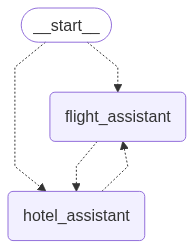

In [8]:
from IPython.display import Image, display
display(Image(swarm.get_graph().draw_mermaid_png()))


In [9]:
for chunk in swarm.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "book a flight from BOS to JFK and a stay at McKittrick Hotel"
            }
        ]
    }
):
    print(chunk)
    print("\n")


{'flight_assistant': {'messages': [HumanMessage(content='book a flight from BOS to JFK and a stay at McKittrick Hotel', additional_kwargs={}, response_metadata={}, id='73be98df-e670-43ba-a471-60d4309e5d06'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_j7yq', 'function': {'arguments': '{"from_airport":"BOS","to_airport":"JFK"}', 'name': 'book_flight'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 95, 'prompt_tokens': 994, 'total_tokens': 1089, 'completion_time': 0.079166667, 'prompt_time': 0.123883152, 'queue_time': 0.246370867, 'total_time': 0.203049819}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'tool_calls', 'logprobs': None}, name='flight_assistant', id='run-bcd15473-edd5-4603-822a-63195112aa31-0', tool_calls=[{'name': 'book_flight', 'args': {'from_airport': 'BOS', 'to_airport': 'JFK'}, 'id': 'call_j7yq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 994, 'output_tokens'